In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c wind-turbine-damage-challenges
!unzip /content/wind-turbine-damage-challenges.zip

# Object Detection with Faster RCNN

Code is for the following video: https://www.youtube.com/watch?v=Uc90rr5jbA4&t=71s

Do give this notebook a thumbs-up if you liked it. Thanks!

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

We require the latest version of torchvision

In [ ]:
# !pip install -U torchvision # We need a new versino of torchvision for this project

Here are all the necessary libraries

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            # A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2(),

        ], bbox_params=A.BboxParams(format='coco', clip=True))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='coco', clip=True))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [ ]:
!python --version

Python 3.11.12


In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        # image = cv2.imread(os.path.join(self.root, self.split, path))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(os.path.join(self.root, self.split, path))
        return np.array(image)

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:

            # boxes =  np.clip(boxes, 0.0, 1.0).tolist()
            transformed = self.transforms(image=image, bboxes=boxes)

            image = transformed['image']
            boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

            # print(xmin, ymin, xmax, ymax)

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

        image =  image.div(255) # scale images
        # print(image)
        # print(type(image))
        # print(targ['boxes'])
        return image, targ

    def __len__(self):
        return len(self.ids)

In [ ]:
# dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined/"
dataset_path = '/content/Wind Turbine damage'

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


{0: {'id': 0, 'name': 'damage', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'corrosion', 'supercategory': 'damage'},
 2: {'id': 2, 'name': 'lightning', 'supercategory': 'damage'},
 3: {'id': 3, 'name': 'lightning receptor', 'supercategory': 'damage'},
 4: {'id': 4, 'name': 'missing teeth', 'supercategory': 'damage'},
 5: {'id': 5, 'name': 'patch', 'supercategory': 'damage'}}

This code just gets a list of classes

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['damage',
 'corrosion',
 'lightning',
 'lightning receptor',
 'missing teeth',
 'patch']

In [ ]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(train=True))
valid_dataset = AquariumDetection(root=dataset_path, split='valid', transforms=get_transforms(train=False))

# train_dataset = AquariumDetection(root=dataset_path)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

In [ ]:
train_dataset

Dataset AquariumDetection
    Number of datapoints: 754
    Root location: /content/Wind Turbine damage
    Compose([
  Resize(p=1.0, height=600, interpolation=1, mask_interpolation=0, width=600),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True, 'clip': True, 'max_accept_ratio': None}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

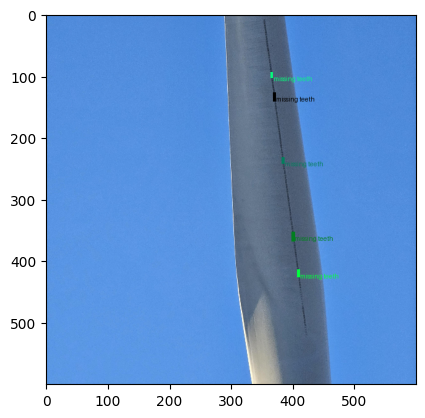

In [ ]:
# Lets view a sample
sample = train_dataset[5]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

754

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [ ]:
n_classes=5

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 76.2MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


loaders = {
    'train': train_loader,
    'valid': valid_loader
}

The following blocks ensures that the model can take in the data and that it will not crash during training

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [ ]:
import sys

In [ ]:
def train(model, optimizer, loaders, device, epochs, scheduler=None):

    model.to(device)
    model.train()

    history_losses = {'train': [], 'valid': []}
    for e in range(epochs):
        for stage, cur_loader in loaders.items():

            all_losses = []
            all_losses_dict = []

            for images, targets in tqdm(cur_loader):
                images = list(image.to(device) for image in images)
                targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

                if stage == 'train':
                    loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets

                    losses = sum(loss for loss in loss_dict.values())
                    loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
                    loss_value = losses.item()

                    all_losses.append(loss_value)
                    all_losses_dict.append(loss_dict_append)
                    if not math.isfinite(loss_value):
                          print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
                          print(loss_dict)
                          sys.exit(1)

                    optimizer.zero_grad()
                    losses.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = model(images)




                        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
                        losses = sum(loss for loss in loss_dict.values())
                        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
                        loss_value = losses.item()

                        all_losses.append(loss_value)
                        all_losses_dict.append(loss_dict_append)
                        if scheduler:
                            scheduler.step(losses)
                        if not math.isfinite(loss_value):
                              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
                              print(loss_dict)
                              sys.exit(1)


            cur_mean_loss = np.mean(all_losses)/len(loss_dict)
            all_losses_dict = pd.DataFrame(all_losses_dict)
            loss_cl = all_losses_dict['loss_classifier'].mean()
            loss_box = all_losses_dict['loss_box_reg'].mean()
            loss_rgn_box = all_losses_dict['loss_rpn_box_reg'].mean()
            loss_obj = all_losses_dict['loss_objectness'].mean()

            history_losses[stage].append([cur_mean_loss, loss_cl, loss_box, loss_rgn_box, loss_obj])

            if stage == 'valid':
                print("Epoch {}, lr: {:.6f}, mean_loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
                    e, optimizer.param_groups[0]['lr'], cur_mean_loss, loss_cl, loss_box, loss_rgn_box, loss_obj
                ))
    return losses

In [ ]:
def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    """Calculate Precision, Recall for single IoU threshold"""
    tp, fp, fn = 0, 0, 0

    for pred_box in pred_boxes:
        max_iou = 0.0
        for true_box in true_boxes:
            iou = calculate_iou(pred_box, true_box)
            max_iou = max(max_iou, iou)

        if max_iou >= iou_threshold:
            tp += 1
        else:
            fp += 1

    fn = len(true_boxes) - tp
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

def calculate_iou(boxA, boxB):
    """Calculate Intersection over Union (IoU)"""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter_area / (boxA_area + boxB_area - inter_area + 1e-6)

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.Adam(params, lr=1e-2)
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
num_epochs=50

losses = train(model, optimizer, loaders, device, num_epochs)

 24%|██▍       | 45/189 [00:28<01:33,  1.54it/s]

In [ ]:
torch.save(model.state_dict(), '/content/ws.pth')

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [ ]:
load_path = '/content/ws_200_epochs.pth'
model.load_state_dict(torch.load(load_path, weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def test_transform():
    transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2(),
    ])
    return transform

In [ ]:
def predict_image(model, image_path, confidence_threshold=0.3):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tr = test_transform()
    image = tr(image=np.array(image))

    image = image['image']
    image = image.div(255)
    with torch.no_grad():
        predictions = model([image])


    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()

    keep = scores >= confidence_threshold
    return boxes[keep], scores[keep], labels[keep]

In [ ]:
def plot_predictions(image_path, boxes, scores, labels, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box, score, label in zip(boxes, scores, labels):
        if score < 0.5:
            continue

        xmin, ymin, xmax, ymax = map(int, box)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        text = f"{class_names[label]}: {score:.2f}"
        cv2.putText(image, text, (xmin, ymin-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
TEST_FOLDER = "/content/Wind Turbine damage/test"
CLASS_NAMES = ["corrosion", "lightning", "lightning receptor", "missing teeth", "patch"]  # классы


dic_pred = {}

for filename in tqdm(os.listdir(TEST_FOLDER)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(TEST_FOLDER, filename)

        boxes, scores, labels = predict_image(model, image_path)

        cur_pred = []

        for i in range(len(boxes)):
            # print(labels[i])
            label = CLASS_NAMES[labels[i]-1]
            x_min = float(boxes[i][0])
            y_min = float(boxes[i][1])
            width = float(boxes[i][2] - x_min)
            height = float(boxes[i][3] - y_min)
            score = float(scores[i])

            cur_pred.append([label, x_min, y_min, width, height, score])

        dic_pred[filename] = cur_pred

        # plot_predictions(image_path, boxes, scores, labels, CLASS_NAMES)

        # if SAVE_RESULTS:
        #     result_image = cv2.cvtColor(plt.gcf().canvas.renderer.buffer_rgba(), cv2.COLOR_RGBA2BGR)
        #     cv2.imwrite(f"results/{filename}", result_image)

100%|██████████| 151/151 [03:43<00:00,  1.48s/it]


In [ ]:
ex_sub = pd.read_csv('/content/sample_submission_with_errors.csv')
df_submit = ex_sub.copy()

for i, row in df_submit.iterrows():
    cur_name = row['image_id']
    upd_val = dic_pred[cur_name]
    df_submit.at[i, 'objects'] = upd_val

df_submit.to_csv('submit___200___epochs.csv', index=False, )

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))